In [1]:
%cd "~/Skorch/ProtienDT/Fang'sTask"

/home/myf/Skorch/ProtienDT/Fang'sTask


In [2]:
import torch #type:ignore
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:",device)

import numpy as np #type:ignore
from meta_net import *
import MoNet as mn
from sklearn.pipeline import Pipeline #type:ignore
from sklearn.preprocessing import StandardScaler #type:ignore
from sklearn.decomposition import PCA #type:ignore

def model_init(module,jobName,load_mode=0):
    # 回调函数#type:ignore
    from skorch.callbacks import Checkpoint, TrainEndCheckpoint , EarlyStopping #type:ignore
    from meta_net.load import LoadCopyState
    cp_val = Checkpoint(dirname="model/"+jobName,f_pickle="model.pt",monitor='valid_loss_best',fn_prefix='val_')#type:ignore
    cp_end = TrainEndCheckpoint(dirname="model/"+jobName,f_pickle="model.pt",fn_prefix='end_')
    init_state=[None,LoadInitState(cp_val),LoadCopyState(cp_val),LoadCopyState(cp_end),LoadInitState(cp_end)][load_mode]

    # 模型运行
    module.set_params(
        optimizer=torch.optim.NAdam,  # 优化器 #type:ignore
        max_epochs=100,  # 最大迭代次数
        batch_size=128,  # 批次大小
        callbacks=[EarlyStopping(monitor='valid_loss',patience=10,load_best=True), #type:ignore
                   init_state,cp_val,cp_end], 
        device=device,  # 使用cpu或者cuda #type:ignore
        warm_start=True,
        iterator_train__shuffle=True
    )

    model = Pipeline([('sc',StandardScaler()),('pca',PCA(n_components=256)),('nn',module)])
    print(model)
    return model

def run_model(model,X, y,Reg_mode=1):
    from sklearn.model_selection import train_test_split #type:ignore
    from torchsummary import summary
    summary((module:=model['nn']).module,input_data=[256],depth=128)
    
    train_X, test_X, train_y, test_y, train_c, test_c = train_test_split(X, y, Y2, stratify=Y2, test_size=0.2, random_state=2023)
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, stratify=train_c,test_size=0.1, random_state=2023)
    model.fit(train_X,train_y)
    
    print(train_score:="train_score: %.3f"%model.score(train_X,train_y)+f" num:{len(train_X)}")
    print(valid_score:="valid_score: %.3f"%model.score(valid_X,valid_y)+f" num:{len(valid_X)}")
    print(test_score :="test_score : %.3f"%model.score(test_X,test_y)+f" num:{len(test_X)}")
    
    import matplotlib.pyplot as plt
    import pandas as pd
    import sklearn.metrics as M
    fig,axs=plt.subplots(1,4,figsize=(20,4))
    
    # print(M.classification_report(y,model.predict(X),zero_division=0))
    pd.DataFrame(module.history[:,label:=('train_loss','dur','valid_loss')],columns=label).plot(ax=axs[0])
    axs[0].set_title(f"Best epoch:{len(best:=module.history[:,'valid_loss_best'])-best[::-1].index(True)}")
    if Reg_mode:
        pd.DataFrame([*(y_true:=train_y).T,*(y_pred:=model.predict(train_X)).T],index=['True','Pred']).T.plot.scatter(x=0,y=1,c=y_pred-y_true,cmap='viridis',ax=axs[1])
        pd.DataFrame([*(y_true:=test_y).T,*(y_pred:=model.predict(test_X)).T],index=['True','Pred']).T.plot.scatter(x=0,y=1,c=y_pred-y_true,cmap='viridis',ax=axs[2])
        pd.DataFrame(PCA(2).fit_transform(X)).plot.scatter(x=0,y=1,c=(error:=model.predict(X)-y),cmap='viridis',ax=axs[3])
    else:
        M.ConfusionMatrixDisplay(M.confusion_matrix(y_true=train_y,y_pred=model.predict(train_X))).plot(ax=axs[1])
        M.ConfusionMatrixDisplay(M.confusion_matrix(y_true=test_y,y_pred=model.predict(test_X))).plot(ax=axs[2])
        pd.DataFrame(PCA(2).fit_transform(X)).plot.scatter(x=0,y=1,c=(error:=model.predict(X)-y),cmap='viridis',ax=axs[3])
        
    axs[1].set_title(train_score)
    axs[2].set_title(test_score)
    axs[3].set_title("mean_error: %.3f"%error.mean())
    
    fig.suptitle(jobName)
    torch.save(model,f"model/{jobName}.final.pt")

device: cuda
pytorch: 2.1.1+cu121 device: cuda


(10959, 7) Index(['Protein', 'Sequence', 'len',
       'Similarity plus ratio/Number of products', 'Number of products',
       'Final product similarity', 'Str_X'],
      dtype='object')


<Axes: ylabel='Frequency'>

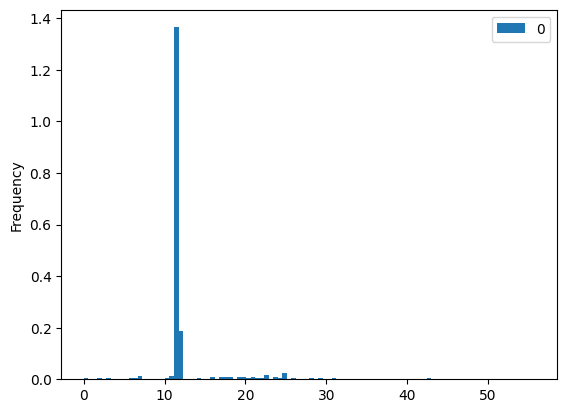

In [3]:
# 加载数据
import pandas as pd #type:ignore
import safetensors.torch as sft #type:ignore
plt.style.use('default')

data=pd.read_pickle("data/data.pkl")
print(data.shape, data.columns) #type:ignore
Y_list = (Y1,Y2,Y3)=data['Similarity plus ratio/Number of products'],data['Number of products'] ,data['Final product similarity'] #type:ignore
y = Y3.to_numpy().reshape(-1,1).astype(np.float32)*1e6
pd.DataFrame(y).plot.hist(bins=100,density=True)

回归

<class 'numpy.dtypes.Float32DType'> (10959, 320) 
 <class 'numpy.dtypes.Float32DType'> (10959, 320) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.2, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=128, bias=Tru...
                  (1:bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2:act): ReLU()
                  (3:dp): Dropout(p=0.2, inplace=False)
                )
              )
              (3): Cell(
                (Net): Sequential(
                  (0:fc): Linear(

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        3.6611        0.8251     +  0.4238
      2        1.2428        1.1755        0.4220
      3        1.2281        0.7813     +  0.4291
      4        1.1695        0.9212        0.4147
      5        1.0981        0.9460        0.4029
      6        1.0908        0.8114        0.3673
      7        1.0128        0.9746        0.4347
      8        0.9996        0.6372     +  0.5869
      9        0.9606        0.6962        0.4258
     10        0.9478        0.6634        0.3797
     11        0.8911        0.7504        0.4965
     12        0.9242        0.6998        0.4704
     13        0.8931        0.5969     +  0.4595
     14        0.8845        0.7316        0.4316
     15        0.8570        0.6729        0.4207
     16        0.8289        0.8237        0.4091
     17        0.8174        0.6481        0.3766
     18        0.8109        0.5859     +  0.4788


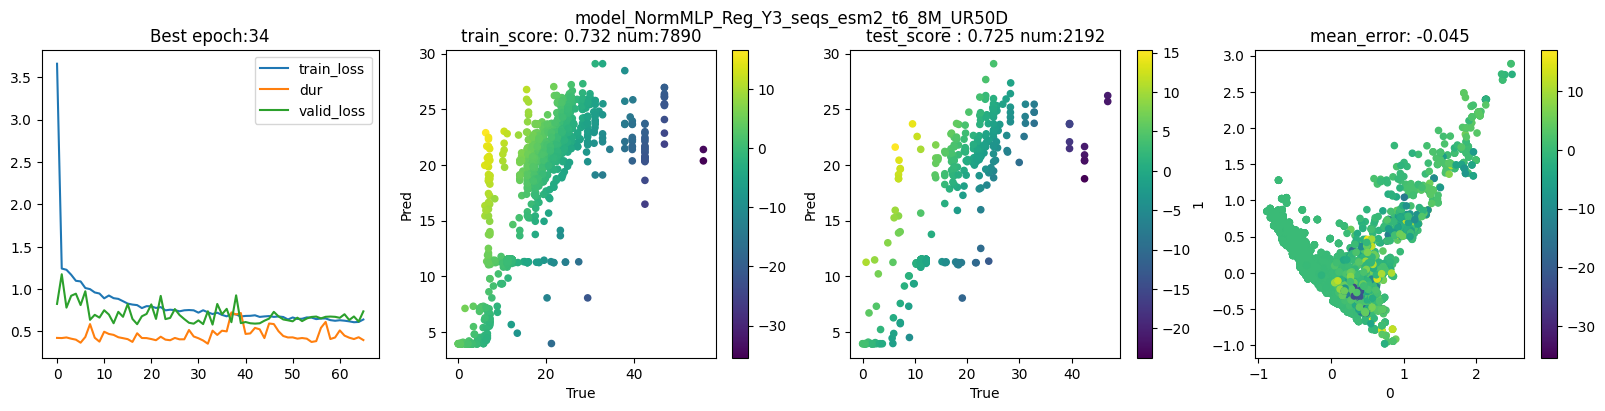

In [18]:
model="NormMLP_Reg_Y3"
Embedding="seqs_esm2_t6_8M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module = R(mn.Layer(1,1,'dp_0.2')*mn.Mix(0,
    [[128,128,64,64],1],
    [["fc", "bn",'act.ReLU',"dp_0.2"], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.SmoothL1Loss,
    optimizer__lr=0.015,
    max_epochs=1000,
    callbacks__EarlyStopping__patience=32)

run_model(model,X,y)

<class 'numpy.dtypes.Float32DType'> (10959, 1280) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1280) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.5, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=128, bias=Tru...
                  (1:bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2:act): ReLU()
                  (3:dp): Dropout(p=0.2, inplace=False)
                )
              )
              (3): Cell(
                (Net): Sequential(
                  (0:fc): Linea

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        3.9650        0.9831     +  0.3059
      2        1.4944        0.7186     +  0.2714
      3        1.4424        0.8705        0.2691
      4        1.3130        0.7464        0.2684
      5        1.2823        0.8293        0.2748
      6        1.2602        0.8169        0.2726
      7        1.1673        0.7346        0.2631
      8        1.1592        1.0060        0.2586
      9        1.1467        0.9735        0.2872
     10        1.1052        0.7373        0.2681
     11        1.0674        0.8751        0.2656
     12        1.0853        0.6913     +  0.2659
     13        1.0490        0.6635     +  0.2624
     14        1.0340        0.8179        0.2695
     15        1.0201        1.0069        0.2710
     16        0.9960        0.8086        0.2711
     17        0.9807        0.6297     +  0.2713
     18        0.9758        0.6629        0.2719


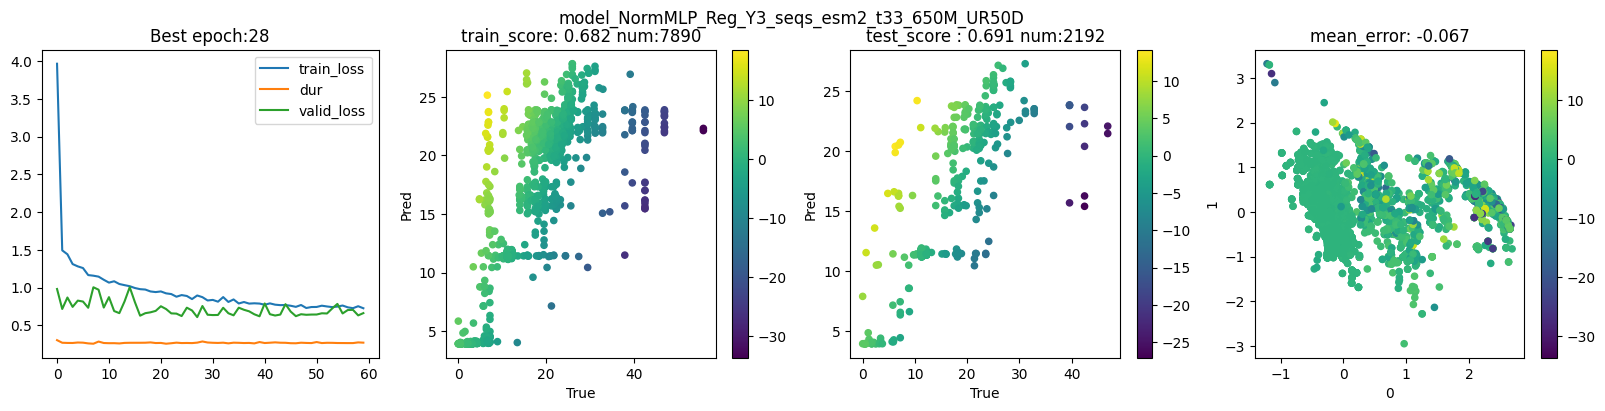

In [50]:
model="NormMLP_Reg_Y3"
Embedding="seqs_esm2_t33_650M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module = R(mn.Layer(1,1,'dp_0.5')*mn.Mix(0,
    [[128,128,64,64],1],
    [["fc", "bn",'act.ReLU',"dp_0.2"], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.SmoothL1Loss,
    optimizer__lr=0.015,
    max_epochs=1000,
    callbacks__EarlyStopping__patience=32)

run_model(model,X,y)

<class 'numpy.dtypes.Float32DType'> (10959, 1282) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1282) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.2, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=256, bias=Tru...
                  (3:dp): Dropout(p=0.5, inplace=False)
                )
              )
              (1): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=256, out_features=128, bias=True)
                  (1:bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        4.1414        2.1753     +  0.2311
      2        2.0314        1.3993     +  0.1786
      3        1.7526        1.1880     +  0.1684
      4        1.6216        1.2067        0.1666
      5        1.5367        1.2538        0.1788
      6        1.4405        1.1424     +  0.1662
      7        1.3911        1.5682        0.1597
      8        1.3475        1.2482        0.1525
      9        1.3075        1.2155        0.2339
     10        1.2741        1.3276        0.1553
     11        1.2872        1.1492        0.1967
     12        1.2212        1.1732        0.1821
     13        1.1967        1.3143        0.1594
     14        1.1913        1.1777        0.2066
     15        1.1626        1.3818        0.1694
     16        1.1392        1.1296     +  0.2174
     17        1.1403        1.1408        0.1587
     18        1.1079        1.0974     +  0.2228


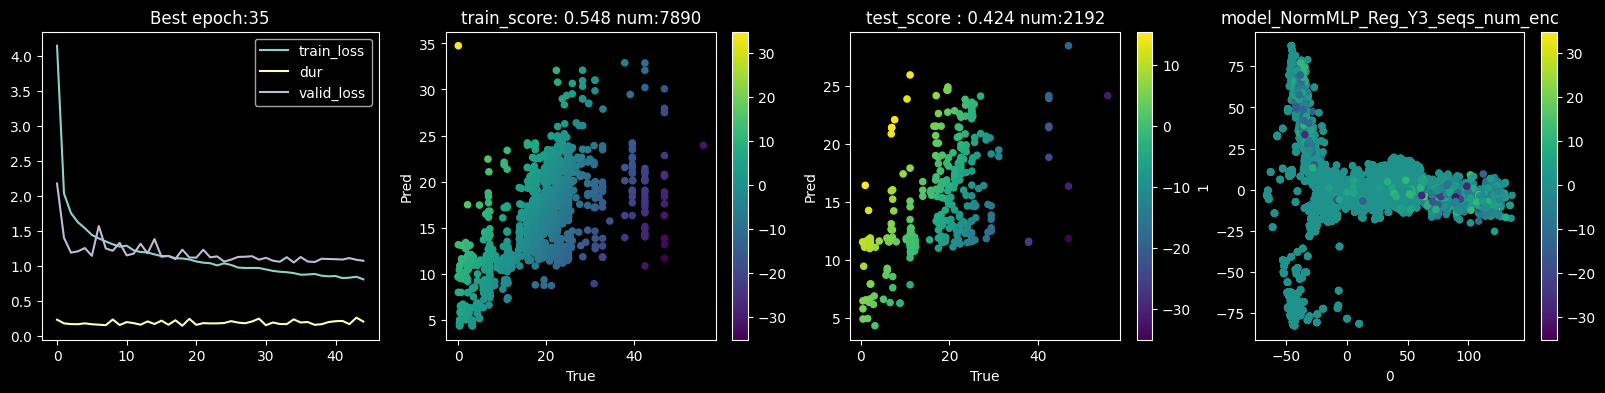

In [71]:
model="NormMLP_Reg_Y3"
Embedding="seqs_num_enc"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module = R(mn.Layer(1,1,'dp_0.2')*mn.Mix(0,
    [[256,128],1],
    [["fc", 'bn', 'act.GELU', 'dp_0.5'], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.SmoothL1Loss,
    optimizer__lr=0.015,
    max_epochs=100,
    callbacks__EarlyStopping__patience=10)

run_model(model,X,y)

<class 'numpy.dtypes.Float32DType'> (10959, 1280, 23) 
 <class 'numpy.dtypes.Float32DType'> (10959, 29440) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.2, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=256, bias=Tru...
                  (3:dp): Dropout(p=0.5, inplace=False)
                )
              )
              (1): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=256, out_features=128, bias=True)
                  (1:bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        4.4022        2.0091     +  0.1960
      2        2.1143        1.3517     +  0.1495
      3        1.8243        1.3695        0.1424
      4        1.6093        1.2800     +  0.1641
      5        1.5074        1.3229        0.1520
      6        1.4422        1.4383        0.2016
      7        1.3589        1.2168     +  0.1895
      8        1.3334        1.1427     +  0.2060
      9        1.3029        1.2180        0.1724
     10        1.2598        1.1512        0.2326
     11        1.2456        1.1787        0.1539
     12        1.2328        1.1892        0.1987
     13        1.2031        1.1498        0.2047
     14        1.2203        1.3213        0.2156
     15        1.1884        1.1565        0.2143
     16        1.1718        1.1280     +  0.1946
     17        1.1433        1.1464        0.1539
     18        1.1637        1.1253     +  0.1913


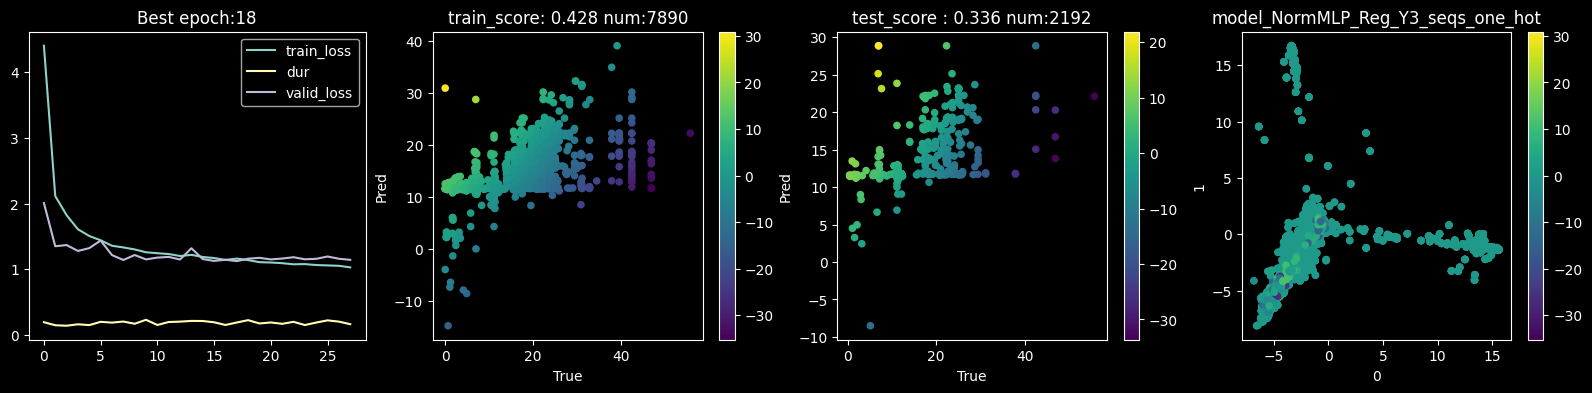

In [72]:
model="NormMLP_Reg_Y3"
Embedding="seqs_one_hot"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module = R(mn.Layer(1,1,'dp_0.2')*mn.Mix(0,
    [[256,128],1],
    [["fc", 'bn', 'act.GELU', 'dp_0.5'], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.SmoothL1Loss,
    optimizer__lr=0.015,
    max_epochs=100,
    callbacks__EarlyStopping__patience=10)

run_model(model,X,y)

推理

In [33]:
model="NormMLP_Reg_Y3"
Embedding="seqs_esm2_t6_8M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载数据
vocab = "-ACDEFGHIKLMNPQRSTVWYUX"
Wild_data = pd.read_pickle('./data/data.pkl').iloc[-1,:]
Wild_Seq = Wild_data['Sequence']

# 突变数据
Mutant_Seqs=[]
for i in range(len(Wild_Seq)):
    Mutant_Seqs+=[ Wild_Seq[:i]+v+Wild_Seq[i+1:] for v in vocab]    

# 编码数据
from meta_net import tokenizer
from tqdm import tqdm
model_load = tokenizer.EsmModelLoad(model = Embedding[5:] ,device= device)

Mutant_Xdata=[]
for i in tqdm(range(len(Wild_Seq))):
    Mutant_Xdata+=tokenizer.EsmEmdMean(Mutant_Seqs[i*len(vocab):(i+1)*len(vocab)],vocab = vocab, model_load=model_load)
Mutant_X=np.array(Mutant_Xdata).reshape(len(Mutant_Xdata),-1).astype(np.float32)
Mutant_X.shape

100%|██████████| 316/316 [00:20<00:00, 15.41it/s]


(7268, 320)

Protein                                                                        Target-Protein
Sequence                                    MVPCSETSDLVEISRFDTRGLGAGYKLRRHKFEHLADAGCHKARSD...
len                                                                                       316
Similarity plus ratio/Number of products                                             0.609867
Number of products                                                                          3
Final product similarity                                                             0.000025
Str_X                                       MVPCSETSDLVEISRFDTRGLGAGYKLRRHKFEHLADAGCHKARSD...
Name: 10975, dtype: object
[[2.3437338e-05]]


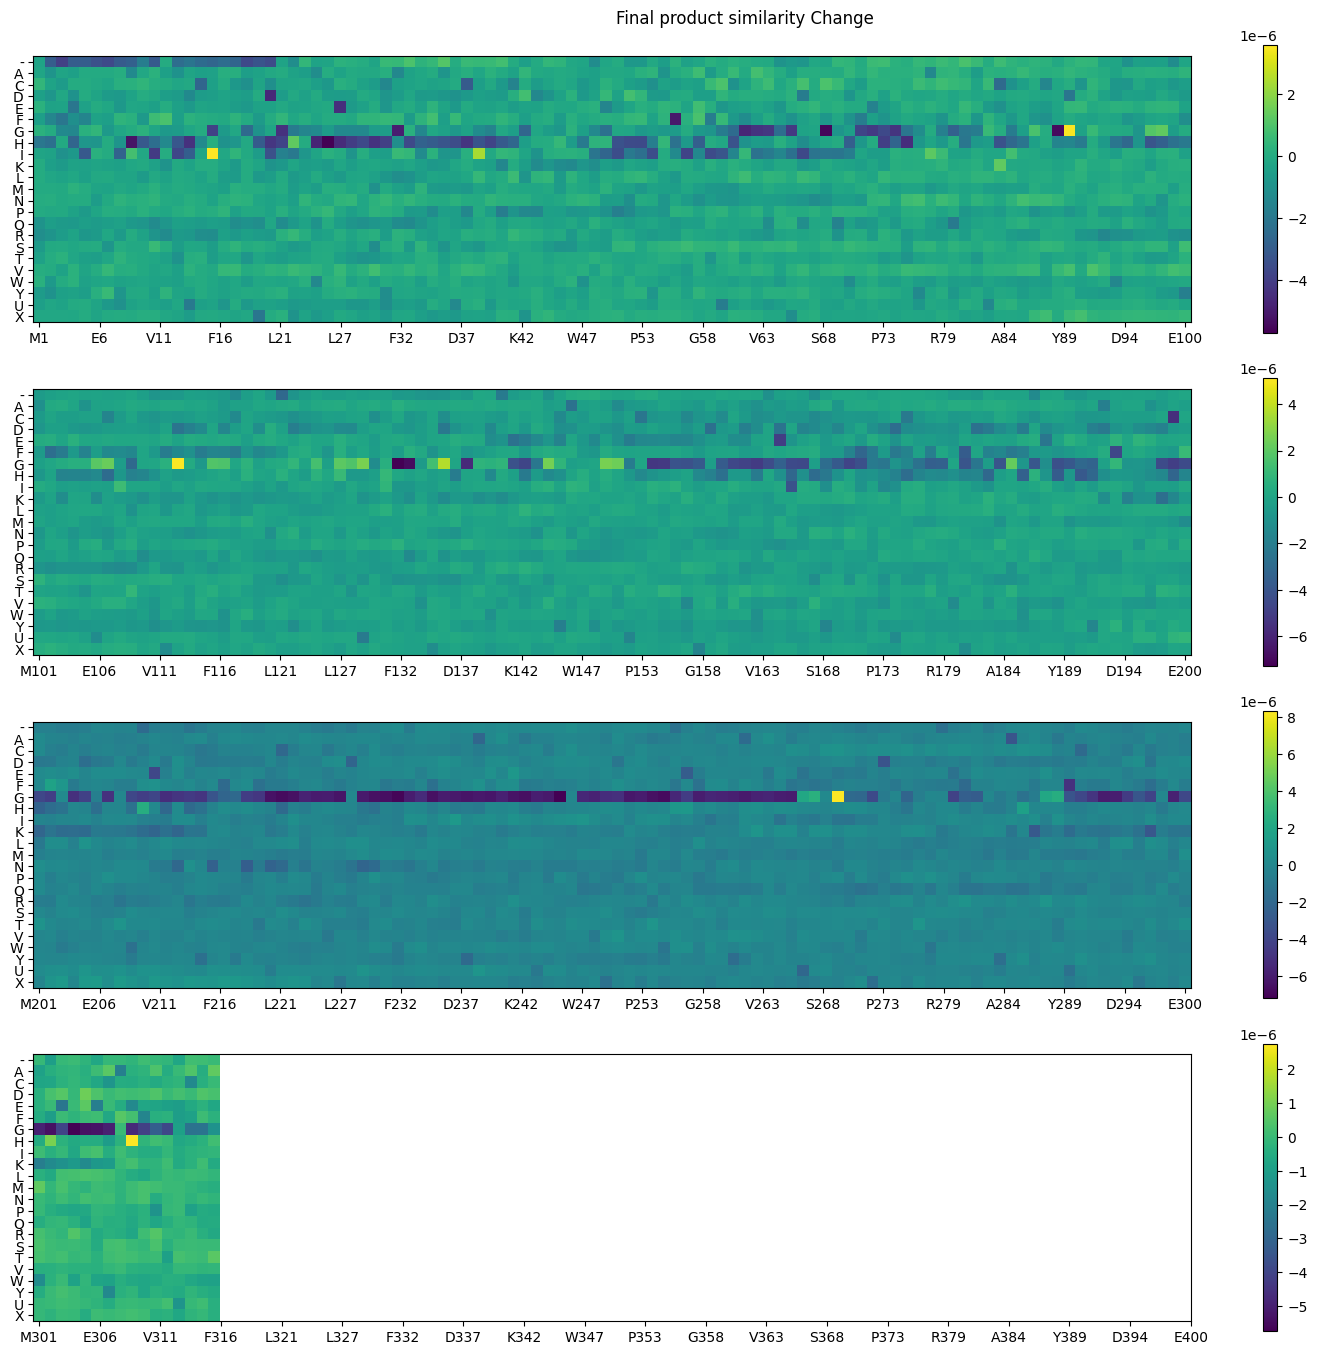

In [93]:
# 加载模型
model = torch.load((f'./model/{jobName}.final.pt'))
print(Wild_data)
print(Wild_y_pred:=model.predict(Mutant_X[vocab.index('M'):vocab.index('M')+1])*1e-6)
d_Mutant_y_pred=model.predict(Mutant_X).reshape(len(vocab),-1)*1e-6-Wild_y_pred

fig,axs=plt.subplots((nrows:=len(Wild_Seq)//100+1),1,figsize=(100*0.15,len(vocab)*0.15*nrows)) # type: ignore
for i in range(nrows):
    ax=axs[i].imshow(d_Mutant_y_pred[:,i*100:(i+1)*100],cmap='viridis')
    axs[i].set_xticks(xt:=np.linspace(0,99,20),
                      [ f"{Wild_Seq[t]}{t+100*i+1}" for t in xt.astype(int)])
    axs[i].set_yticks(np.linspace(0,len(vocab)-1,len(vocab)).astype(int),vocab)
    fig.colorbar(ax, ax=axs[i])
plt.suptitle("Final product similarity Change")
plt.tight_layout()

In [42]:
df=pd.DataFrame(d_Mutant_y_pred,index=list(vocab)).T
df

,-,A,C,D,E,F,G,H,I,K,...,P,Q,R,S,T,V,W,Y,U,X
0,-3.064924e-07,-2.582237e-07,4.103658e-07,-4.069498e-07,2.298530e-07,-4.471804e-07,2.439028e-07,-2.008914e-06,-2.703255e-07,1.818989e-12,...,-9.995347e-09,-9.482137e-07,-1.125061e-06,-6.550654e-07,-3.968271e-07,7.467133e-08,1.831704e-07,-6.161845e-07,-4.669073e-07,-1.329681e-07
1,-2.956684e-06,-9.070809e-07,-3.208970e-07,-8.374955e-07,-3.518562e-07,-1.431781e-06,-6.997652e-09,-2.256371e-06,-3.651148e-07,-4.638314e-07,...,-1.069238e-07,-4.938174e-07,-9.079704e-07,-6.698792e-08,5.397487e-08,1.818989e-12,-6.830651e-07,-9.722608e-07,-2.112920e-07,-1.385597e-07
2,-3.930101e-06,-2.936340e-07,-5.949223e-07,-1.443623e-07,-3.180267e-07,-2.052191e-06,-1.282671e-06,-6.439404e-08,-9.886971e-07,-6.446171e-07,...,-6.387017e-08,-6.534028e-07,-5.632719e-07,-4.240610e-08,2.233519e-07,-3.426103e-07,3.918103e-09,-4.223348e-07,-3.023615e-07,-1.275566e-07
3,-2.957107e-06,-4.379108e-07,1.284934e-08,-9.629694e-07,-2.037519e-06,-1.065528e-06,-1.403179e-06,-2.665472e-06,-7.498420e-07,-3.471268e-07,...,-3.554305e-07,-7.312792e-07,-3.133300e-07,-1.769495e-07,-2.176457e-07,2.435736e-07,2.189499e-07,-3.693676e-07,-9.771611e-09,-1.630997e-07
4,-2.975217e-06,-1.893386e-08,1.818989e-12,1.818989e-12,-3.821515e-07,-1.497150e-06,2.064644e-07,-8.158440e-07,-3.096686e-06,-3.862569e-07,...,-6.515202e-07,-4.857175e-07,-7.733597e-07,-1.231092e-08,-4.133599e-07,-2.932011e-07,-3.815276e-07,-5.090515e-07,1.818989e-12,1.474109e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,-1.501667e-07,-4.879530e-07,-3.148161e-07,-3.417881e-08,-9.219657e-07,-2.922970e-07,-3.911957e-06,-3.825699e-08,-1.346907e-07,9.638825e-08,...,-8.480492e-08,-4.212252e-07,-1.314493e-07,-3.679343e-07,-9.083542e-07,-5.155434e-07,-3.916939e-07,-4.535868e-07,1.867083e-07,-2.944998e-07
312,-7.302242e-07,-4.113463e-08,-1.847675e-07,1.938242e-07,-1.032209e-06,-1.008731e-06,-9.261003e-07,-6.492464e-07,-5.209495e-07,-5.577695e-07,...,1.818989e-12,-1.148692e-07,-1.741137e-07,2.332672e-08,2.331544e-07,-1.066837e-07,-4.305566e-07,-5.670754e-07,-1.333028e-06,-6.974733e-07
313,1.458357e-07,4.001213e-07,-1.723234e-06,2.259549e-08,-5.875099e-07,-8.823827e-07,-2.541321e-06,-5.295497e-07,-3.080477e-07,-3.338228e-07,...,-8.705319e-07,-2.314009e-07,-1.871740e-09,5.126822e-08,9.885116e-08,-1.009121e-07,-6.696064e-07,-1.818553e-07,-6.678420e-08,-2.134093e-07
314,1.028748e-07,-4.673675e-07,-3.998648e-07,4.091962e-07,-2.956167e-07,7.663948e-08,-2.512283e-06,-3.339046e-07,-2.082670e-07,1.237713e-07,...,-5.332549e-07,-5.476886e-07,-4.044523e-07,1.818989e-12,3.651076e-08,-1.796270e-07,-8.482275e-07,-4.371195e-07,1.043518e-07,-1.018998e-07


Text(0.5, 1.0, 'Final product similarity Change')

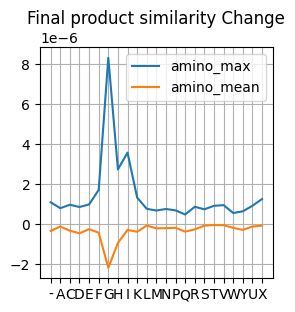

In [87]:
df=pd.DataFrame(d_Mutant_y_pred,index=list(vocab)).T
df.max(axis=0).plot(figsize=(3,3),label='amino_max')
df.mean(axis=0).plot(figsize=(3,3),label='amino_mean')
plt.xticks(np.linspace(0,len(vocab)-1,len(vocab)),vocab)
plt.grid()
plt.legend()
plt.title("Final product similarity Change")

Text(0.5, 1.0, 'Final product similarity Change')

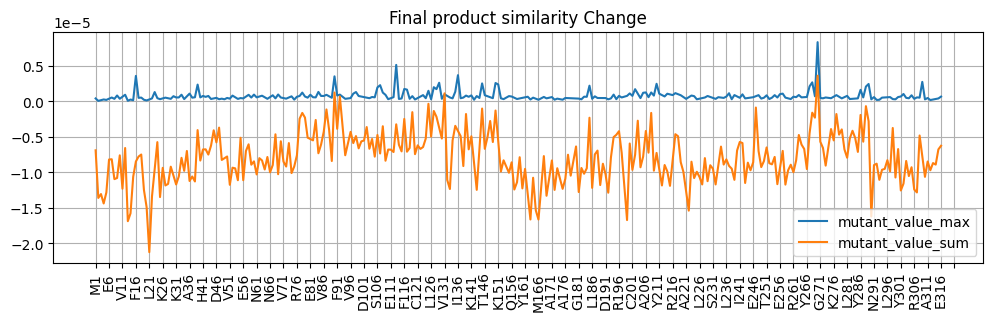

In [88]:
df.max(axis=1).plot(figsize=(12,3),label='mutant_value_max')
df.sum(axis=1).plot(figsize=(12,3),label='mutant_value_sum')
plt.xticks(xt:=np.linspace(0,320,320//5+1),[ f"{Wild_Seq[i]}{i+1}" for i in xt[:-1].astype(int)]+[''],rotation=90)
plt.grid()
plt.legend()
plt.title("Final product similarity Change")